# Build a CNN audio classifier using melspectograms from Audioset and ESC-50 data

## Load required modules

In [1]:
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
import numpy as np
import json
import os
import shutil
import random
import itertools
import matplotlib.pyplot as plt
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17070039307598391372
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 15559258932
locality {
  bus_id: 1
}
incarnation: 10869534684202922379
physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0"
]


## Utility functions

In [3]:
def split_dataset(file_paths, label_dir, train_split):
    # get new train and validation indices
    n_files = len(file_paths)
    n_train = int(train_split * n_files)
    train_idx = random.sample(range(n_files), n_train)
    val_idx = list(set(range(n_files)) - set(train_idx))
    
    # split files
    train_set = [file_paths[idx] for idx in train_idx]
    val_set = [file_paths[idx] for idx in val_idx]

    return train_set, val_set

In [4]:
# create and save train and validation splits into tmp directories
def train_and_val_split(path_to_train_set, train_split, seed=23):
    random.seed(seed)

    train_labels = os.listdir(path_to_train_set)
    print '{} classes observed'.format(len(train_labels))
    
    # split original files
    train_dir = '/tmp/train'
    val_dir = '/tmp/val'
    n_train_files = 0
    n_val_files = 0
    for label_dir in train_labels:
        # fill in dictionary
        full_path_to_dir = os.path.join(path_to_train_set, label_dir)
        files = os.listdir(full_path_to_dir) 
        file_paths = [os.path.join(path_to_train_set, label_dir, f) for f in files]
        train_set, val_set = split_dataset(file_paths, label_dir, train_split)
        
        # copy files over to tmp directories
        train_label_dir = os.path.join(train_dir, label_dir)
        if os.path.exists(train_label_dir):
            shutil.rmtree(train_label_dir)
        os.makedirs(train_label_dir)
            
        val_label_dir = os.path.join(val_dir, label_dir)
        if os.path.exists(val_label_dir):
            shutil.rmtree(val_label_dir)
        os.makedirs(val_label_dir)
        
        def tmp_train_path(f):
            base_filename = os.path.basename(f)
            return os.path.join(train_label_dir, base_filename)
        def tmp_val_path(f):
            base_filename = os.path.basename(f)
            return os.path.join(val_label_dir, base_filename)
        
        map(lambda f: shutil.copyfile(f, tmp_train_path(f)), train_set)
        map(lambda f: shutil.copyfile(f, tmp_val_path(f)), val_set)
        
        n_train_files += len(train_set)
        n_val_files += len(val_set)
                 
    print 'Found {} files for train set'.format(n_train_files)
    print 'Found {} files for validaiton set'.format(n_val_files)
                 
    return train_dir, val_dir

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Set parameter values

In [6]:
data_source = 'melspectrograms'
batch_size = 40
epochs = 150

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

# Configure training and validation data generators

In [7]:
training_data_dir = '../hackathon_dataset/{}/train'.format(data_source)

In [8]:
# training generator configuration
training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 3716 images belonging to 2 classes.


In [9]:
validation_data_dir = '../hackathon_dataset/{}/validation'.format(data_source)

In [10]:
# validation generator configuration
validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 1219 images belonging to 2 classes.


In [11]:
nb_training_samples = 3716
nb_validation_samples = 1219
n_classes = len(os.listdir(training_data_dir)) - 1
class_labels = os.listdir(training_data_dir)[:-1]

# Load base model

In [12]:
model_name = 'vgg16'
pretrained_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded')
print pretrained_model.summary()

Model loaded
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0       

In [13]:
print 'vgg16 contain {} layers'.format(len(pretrained_model.layers))

vgg16 contain 19 layers


In [14]:
#num_layers_to_freeze = len(pretrained_model.layers) - 2

In [30]:
num_layers_to_freeze = len(pretrained_model.layers) - 6

# Build top model

In [31]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=pretrained_model.output_shape[1:]))
top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.6))
top_model.add(Dense(n_classes, activation='softmax'))
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 3,211,650
Trainable params: 3,211,650
Non-trainable params: 0
_________________________________________________________________


# Combine base model with top model

In [32]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=pretrained_model.input, outputs=top_model(pretrained_model.output))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Configure model training

In [33]:
if not os.path.exists('models/json_models'):
    os.makedirs('models/json_models')

In [34]:
from keras import metrics, optimizers

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# regualr SGD
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# serialize model to JSON
model_json = model.to_json()
model_filename = "models/json_models/audioset_nesterov_{}_{}_{}_frozen_layers_dropout_60pct.json"\
                    .format(model_name, data_source, num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

# Fine-tune the model

In [35]:
if not os.path.exists('models/weights'):
    os.makedirs('models/weights')

In [36]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

# set up log files for tensorboard
tensorboard = TensorBoard(log_dir="logs/vgg16_{}_layers_frozen".format(num_layers_to_freeze))

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# checkpoint
filepath="vgg16_melspec_weights_freeze_{}_base_layers.best.hdf5".format(num_layers_to_freeze)
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard, early_stopping]

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)

Epoch 1/10
92/92 [==============================] - 51s - loss: 5.5619 - acc: 0.5976 - val_loss: 6.1930 - val_acc: 0.6158
Epoch 2/10
92/92 [==============================] - 47s - loss: 4.9491 - acc: 0.6127 - val_loss: 6.1793 - val_acc: 0.6166
Epoch 3/10
92/92 [==============================] - 45s - loss: 5.0403 - acc: 0.6125 - val_loss: 6.2476 - val_acc: 0.6124
Epoch 4/10
92/92 [==============================] - 45s - loss: 4.9694 - acc: 0.6116 - val_loss: 6.2203 - val_acc: 0.6141
Epoch 5/10
92/92 [==============================] - 43s - loss: 5.0605 - acc: 0.6070 - val_loss: 6.2887 - val_acc: 0.6098
Epoch 6/10
92/92 [==============================] - 43s - loss: 4.8815 - acc: 0.6168 - val_loss: 5.9469 - val_acc: 0.6310
Epoch 7/10
92/92 [==============================] - 43s - loss: 5.1117 - acc: 0.6134 - val_loss: 6.3297 - val_acc: 0.6073
Epoch 8/10
92/92 [==============================] - 43s - loss: 5.0380 - acc: 0.6143 - val_loss: 6.1930 - val_acc: 0.6158
Epoch 9/10
92/92 [======

# Calculate and plot confusion matrix

Normalized confusion matrix


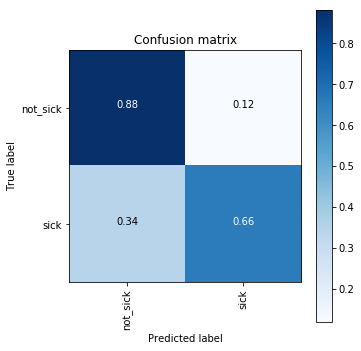

In [22]:
import os
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for label in class_labels:
    file_list = os.listdir(validation_data_dir + '/' + label)
    for file_name in file_list:
        img_path = validation_data_dir + '/' + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(class_labels[np.argmax(preds)])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(class_labels), normalize=True)

## ADAM

In [27]:
#model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True), 
#                      loss='categorical_crossentropy', 
#                      metrics=['accuracy'])

model.compile(optimizer=optimizers.Adagrad(lr=0.01, epsilon=1e-6), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])
# serialize model to JSON
model_json = model.to_json()
model_filename = "models/json_models/audioset_nesterov_{}_{}_{}_frozen_layers_dropout_60pct.json"\
                    .format(model_name, data_source, num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)
    
if not os.path.exists('models/weights'):
    os.makedirs('models/weights')
    
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

# set up log files for tensorboard
tensorboard = TensorBoard(log_dir="logs/vgg16_{}_layers_frozen".format(num_layers_to_freeze))

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# checkpoint
filepath="vgg16_melspec_weights_freeze_{}_base_layers.best.hdf5".format(num_layers_to_freeze)
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard, early_stopping]

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)

Epoch 1/10
92/92 [==============================] - 51s - loss: 6.9927 - acc: 0.5625 - val_loss: 6.2203 - val_acc: 0.6141
Epoch 2/10
92/92 [==============================] - 47s - loss: 6.3238 - acc: 0.6072 - val_loss: 6.2066 - val_acc: 0.6149
Epoch 3/10
92/92 [==============================] - 49s - loss: 6.2610 - acc: 0.6115 - val_loss: 6.1930 - val_acc: 0.6158
Epoch 4/10
92/92 [==============================] - 48s - loss: 6.1673 - acc: 0.6168 - val_loss: 6.0836 - val_acc: 0.6226
Epoch 5/10
92/92 [==============================] - 46s - loss: 6.2754 - acc: 0.6103 - val_loss: 6.2613 - val_acc: 0.6115
Epoch 6/10
92/92 [==============================] - 44s - loss: 6.1826 - acc: 0.6162 - val_loss: 6.2340 - val_acc: 0.6132
Epoch 7/10
92/92 [==============================] - 44s - loss: 6.2465 - acc: 0.6114 - val_loss: 6.1109 - val_acc: 0.6209
Epoch 8/10
92/92 [==============================] - 44s - loss: 6.2202 - acc: 0.6138 - val_loss: 6.3297 - val_acc: 0.6073
Epoch 9/10
92/92 [======

Normalized confusion matrix


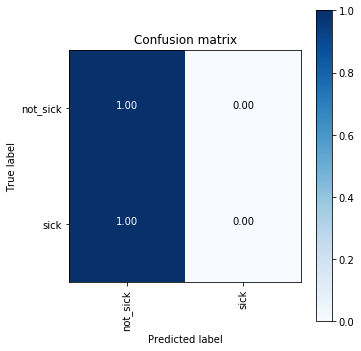

In [28]:
import os
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []
for label in class_labels:
    file_list = os.listdir(validation_data_dir + '/' + label)
    for file_name in file_list:
        img_path = validation_data_dir + '/' + label + '/' + file_name
        
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(class_labels[np.argmax(preds)])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(class_labels), normalize=True)

In [29]:
from keras import metrics, optimizers

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# regualr SGD
model.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.5, decay=1e-8, nesterov=True), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# serialize model to JSON
model_json = model.to_json()
model_filename = "models/json_models/audioset_nesterov_{}_{}_{}_frozen_layers_dropout_60pct.json"\
                    .format(model_name, data_source, num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)
    
# serialize model to JSON
model_json = model.to_json()
model_filename = "models/json_models/audioset_nesterov_{}_{}_{}_frozen_layers_dropout_60pct.json"\
                    .format(model_name, data_source, num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)
    
if not os.path.exists('models/weights'):
    os.makedirs('models/weights')
    
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

# set up log files for tensorboard
tensorboard = TensorBoard(log_dir="logs/vgg16_{}_layers_frozen".format(num_layers_to_freeze))

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# checkpoint
filepath="vgg16_melspec_weights_freeze_{}_base_layers.best.hdf5".format(num_layers_to_freeze)
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard, early_stopping]

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)

Epoch 1/10
92/92 [==============================] - 50s - loss: 6.2383 - acc: 0.6120 - val_loss: 6.2887 - val_acc: 0.6098
Epoch 2/10
92/92 [==============================] - 46s - loss: 6.2230 - acc: 0.6139 - val_loss: 6.0836 - val_acc: 0.6226
Epoch 3/10
92/92 [==============================] - 44s - loss: 6.2643 - acc: 0.6104 - val_loss: 6.2613 - val_acc: 0.6115
Epoch 4/10
92/92 [==============================] - 44s - loss: 6.2464 - acc: 0.6117 - val_loss: 6.1656 - val_acc: 0.6175
Epoch 5/10
92/92 [==============================] - 46s - loss: 6.2770 - acc: 0.6098 - val_loss: 6.1519 - val_acc: 0.6183
Epoch 6/10
92/92 [==============================] - 46s - loss: 6.1907 - acc: 0.6157 - val_loss: 6.1793 - val_acc: 0.6166
Epoch 7/10
92/92 [==============================] - 44s - loss: 6.2581 - acc: 0.6115 - val_loss: 6.1930 - val_acc: 0.6158
Epoch 8/10
92/92 [==============================] - 44s - loss: 6.1469 - acc: 0.6184 - val_loss: 6.1109 - val_acc: 0.6209
Epoch 9/10
92/92 [======